In [30]:
from astropy.io import fits
import pandas as pd
import numpy as np

# Read the DR16 Catalog
f = "../Thesis/DR16Q_v4.fits"
with fits.open(f, memmap=True) as hdu_list:
    data0 = hdu_list[1].data

# Convert relevant columns to a DataFrame
df = pd.DataFrame({
    'PLATE': data0['PLATE'].byteswap().newbyteorder(),
    'MJD': data0['MJD'].byteswap().newbyteorder(),
    'FIBERID': data0['FIBERID'].byteswap().newbyteorder(),
    'SNR': data0['SN_MEDIAN_ALL'].byteswap().newbyteorder(),
    'Z': data0['Z'].byteswap().newbyteorder(),
})

# Add duplicate-related columns as lists
df['PLATES'] = list(data0['PLATE_DUPLICATE'])
df['MJDS'] = list(data0['MJD_DUPLICATE'])
df['FIBERIDS'] = list(data0['FIBERID_DUPLICATE'])

# Filter for Z and SNR
df = df[(df['Z'] >= 1.88) & (df['Z'] <= 2.47) & (df['SNR'] >= 4)]

# Remove quasars without valid duplicates
df = df[df['PLATES'].apply(lambda x: any(i != -1 for i in x))]

# Refine duplicates by filtering out -1 values
def refine_duplicates(column):
    return column.apply(lambda x: [i for i in x if i != -1])

df['PLATES'] = refine_duplicates(df['PLATES'])
df['MJDS'] = refine_duplicates(df['MJDS'])
df['FIBERIDS'] = refine_duplicates(df['FIBERIDS'])
df = df.reset_index(drop=True)

# Total number of available Duplicates per quasar
df['DUPLICATES'] = [len(i) for i in df['PLATES']]
df = df.sort_values('DUPLICATES',ascending=True)
df = df.reset_index(drop=True)

/var/folders/4t/j_nn7fnn2xb1h112k0kt_q1c0000gn/T/ipykernel_12482/3720692552.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


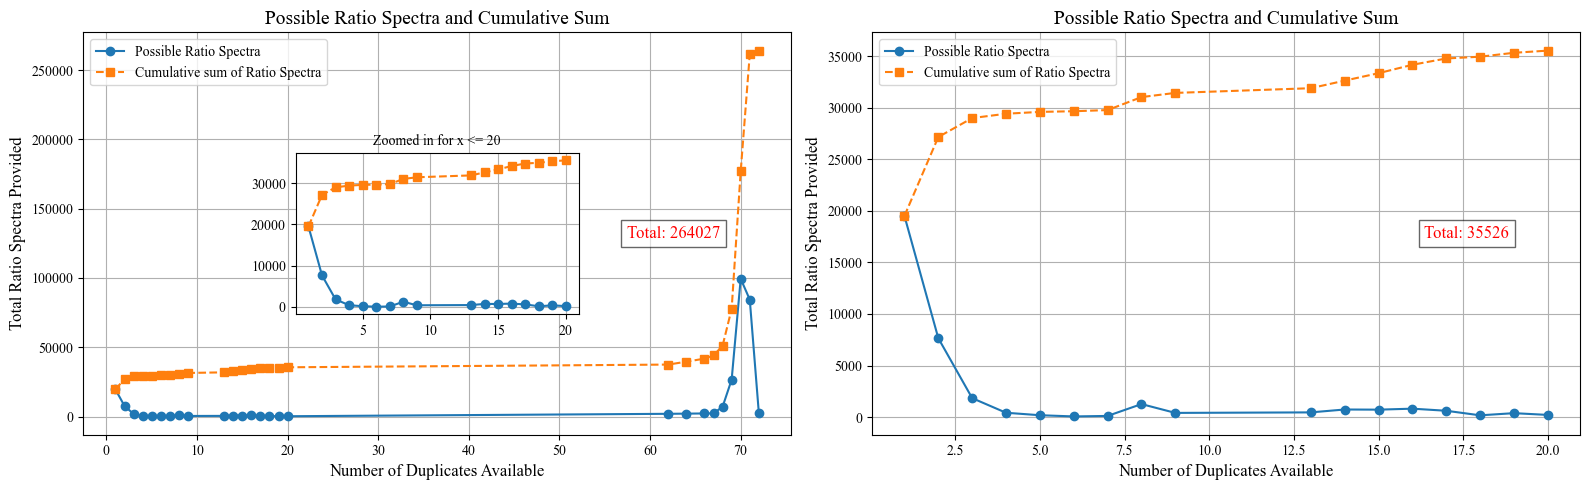

In [48]:
def Total_Possible_RatioSpectra(df, ax, flag=1):
    import math
    from itertools import accumulate
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Create a dictionary of duplicate counts
    a = dict(df.value_counts('DUPLICATES'))
    a = dict(sorted(a.items()))

    # Compute points
    pts = [(i, math.comb(i + 1, 2) * a[i]) for i in a]

    # Extract x and y values
    x, y = zip(*pts)

    # Compute cumulative sum for y
    y_cumsum = list(accumulate(y))

    # Plot on the provided axes
    ax.plot(x, y, label="Possible Ratio Spectra", marker="o")
    ax.plot(x, y_cumsum, label="Cumulative sum of Ratio Spectra", marker="s", linestyle="--")
    ax.set_xlabel("Number of Duplicates Available", fontsize=12)
    ax.set_ylabel("Total Ratio Spectra Provided", fontsize=12)
    ax.set_title("Possible Ratio Spectra and Cumulative Sum", fontsize=14)
    ax.text(0.9, 0.5, f"Total: {y_cumsum[-1]}", transform=ax.transAxes, 
        fontsize=12, color='red', ha='right', va='center', bbox=dict(facecolor='white', alpha=0.6))
    ax.legend()
    ax.grid()

    if flag == 1:
        # Add inset plot
        ax_inset = inset_axes(ax, width="40%", height="40%", loc='center')
        x_inset = [val for val in x if val <= 20]
        y_inset = [y[i] for i, val in enumerate(x) if val <= 20]
        y_cumsum_inset = [y_cumsum[i] for i, val in enumerate(x) if val <= 20]

        # Plot on inset
        ax_inset.plot(x_inset, y_inset, label="y values", marker="o")
        ax_inset.plot(x_inset, y_cumsum_inset, label="Cumulative sum", marker="s", linestyle="--")
        ax_inset.set_title("Zoomed in for x <= 20", fontsize=10)
        ax_inset.grid()


# Example Usage
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# First subplot
Total_Possible_RatioSpectra(df, axes[0], flag=1)

# Second subplot with filtered data
df0 = df[df['DUPLICATES'] < 30]
Total_Possible_RatioSpectra(df0, axes[1], flag=0)

# Adjust layout
plt.tight_layout()
plt.show()

In [50]:
import pandas as pd
from itertools import combinations

df = df0

# Function to generate ratio-identifier rows
def create_ratio_identifiers(row):
    primary = (row['PLATE'], row['MJD'], row['FIBERID'])
    duplicates = zip(row['PLATES'], row['MJDS'], row['FIBERIDS'])

    # Include primary and all duplicates in combinations
    all_spectra = [primary] + list(duplicates)
    identifiers = []

    # Generate all NC2 combinations
    for combo in combinations(all_spectra, 2):
        id1 = f"{combo[0][0]}-{combo[0][1]}-{combo[0][2]}"
        id2 = f"{combo[1][0]}-{combo[1][1]}-{combo[1][2]}"
        identifiers.append(f"spec-{id1}-{id2}")

    return identifiers

# Apply the function to each row and explode the dataframe
df['ratio_identifiers'] = df.apply(create_ratio_identifiers, axis=1)

df_exploded = df.explode('ratio_identifiers').reset_index(drop=True)

# Keep only required columns and rename for clarity
df_exploded = df_exploded[['PLATE', 'MJD', 'FIBERID','Z', 'ratio_identifiers']]

df_exploded

,PLATE,MJD,FIBERID,Z,ratio_identifiers
0,4296,55499,364,2.354,spec-4296-55499-364-7852-56987-417
1,6828,56430,618,2.295,spec-6828-56430-618-8204-58146-292
2,8207,57431,373,2.256,spec-8207-57431-373-6754-56414-712
3,6967,56447,984,2.395,spec-6967-56447-984-783-52325-28
4,6625,56386,575,2.167,spec-6625-56386-575-1461-53062-153
...,...,...,...,...,...
35521,3615,55179,30,2.025,spec-7828-57039-116-4238-55455-74
35522,3615,55179,30,2.025,spec-7828-57039-116-3615-56544-40
35523,3615,55179,30,2.025,spec-3647-55827-34-4238-55455-74
35524,3615,55179,30,2.025,spec-3647-55827-34-3615-56544-40


In [7]:
import pandas as pd
import itertools

# Function to calculate Delta MJD
def calculate_delta_mjd(row):
    # Combine MJDS and MJD into a new list
    mjds = row['MJDS'] + [row['MJD']]
    # Pairwise ΔMJD within the combined list
    delta_mjds = [abs(a - b) for a, b in itertools.combinations(mjds, 2)]
    return delta_mjds

# Apply the function to calculate Delta MJD
df['Delta_MJD'] = df.apply(calculate_delta_mjd, axis=1)

df

,PLATE,MJD,FIBERID,SNR,Z,PLATES,MJDS,FIBERIDS,DUPLICATES,Delta_MJD
0,4296,55499,364,4.118943,2.354,[7852],[56987],[417],1,[1488]
1,6828,56430,618,4.487787,2.295,[8204],[58146],[292],1,[1716]
2,8207,57431,373,4.888992,2.256,[6754],[56414],[712],1,[1017]
3,6967,56447,984,11.757296,2.395,[783],[52325],[28],1,[4122]
4,6625,56386,575,13.140804,2.167,[1461],[53062],[153],1,[3324]
...,...,...,...,...,...,...,...,...,...,...
22396,6780,56605,459,5.466096,2.193,"[6780, 7828, 6370, 6780]","[56267, 57039, 56238, 56577]","[459, 458, 460, 459]",4,"[772, 29, 310, 338, 801, 462, 434, 339, 367, 28]"
22397,6782,56572,91,19.906374,2.189,"[6782, 9311, 6782, 6782]","[56273, 57743, 56576, 56602]","[95, 704, 97, 97]",4,"[1470, 303, 329, 299, 1167, 1141, 1171, 26, 4,..."
22398,4221,55443,607,19.998461,2.230,"[689, 9410, 3587, 7868]","[52262, 58069, 55182, 57006]","[502, 70, 570, 512]",4,"[5807, 2920, 4744, 3181, 2887, 1063, 2626, 182..."
22399,4240,55455,635,5.412910,2.233,"[7825, 3650, 4239, 3651]","[57030, 55244, 55458, 55247]","[828, 754, 958, 556]",4,"[1786, 1572, 1783, 1575, 214, 3, 211, 211, 3, ..."


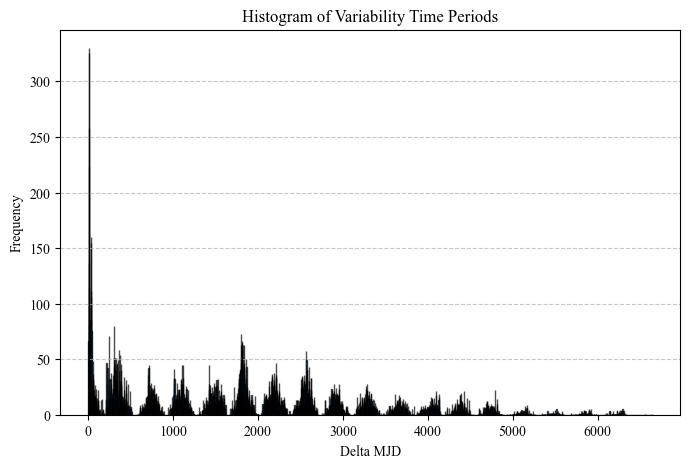

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Combine all lists into a single list
combined_list = [item for sublist in df['Delta_MJD'] for item in sublist]

# Plot a histogram
plt.figure(figsize=(8, 5))
plt.hist(combined_list, bins=range(min(combined_list), max(combined_list) + 2), edgecolor='black', alpha=0.7)
plt.xlabel('Delta MJD')
plt.ylabel('Frequency')
plt.title('Histogram of Variability Time Periods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
import pandas as pd
from itertools import combinations

df = df0

# Function to generate ratio-identifier rows
def create_ratio_identifiers(row):
    primary = (row['PLATE'], row['MJD'], row['FIBERID'])
    duplicates = zip(row['PLATES'], row['MJDS'], row['FIBERIDS'])

    # Include primary and all duplicates in combinations
    all_spectra = [primary] + list(duplicates)
    identifiers = []

    # Generate all NC2 combinations
    for combo in combinations(all_spectra, 2):
        id1 = f"{combo[0][0]}-{combo[0][1]}-{combo[0][2]}"
        id2 = f"{combo[1][0]}-{combo[1][1]}-{combo[1][2]}"
        identifiers.append(f"spec-{id1}-{id2}")

    return identifiers

# Apply the function to each row and explode the dataframe
df['ratio_identifiers'] = df.apply(create_ratio_identifiers, axis=1)

df_exploded = df.explode('ratio_identifiers').reset_index(drop=True)

# Keep only required columns and rename for clarity
df_exploded = df_exploded[['PLATE', 'MJD', 'FIBERID', 'ratio_identifiers']]

df_exploded


/var/folders/4t/j_nn7fnn2xb1h112k0kt_q1c0000gn/T/ipykernel_12482/3331057342.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ratio_identifiers'] = df.apply(create_ratio_identifiers, axis=1)


,PLATE,MJD,FIBERID,ratio_identifiers
0,4296,55499,364,spec-4296-55499-364-7852-56987-417
1,6828,56430,618,spec-6828-56430-618-8204-58146-292
2,8207,57431,373,spec-8207-57431-373-6754-56414-712
3,6967,56447,984,spec-6967-56447-984-783-52325-28
4,6625,56386,575,spec-6625-56386-575-1461-53062-153
...,...,...,...,...
35521,3615,55179,30,spec-7828-57039-116-4238-55455-74
35522,3615,55179,30,spec-7828-57039-116-3615-56544-40
35523,3615,55179,30,spec-3647-55827-34-4238-55455-74
35524,3615,55179,30,spec-3647-55827-34-3615-56544-40


In [29]:
df0

,PLATE,MJD,FIBERID,SNR,Z,PLATES,MJDS,FIBERIDS,DUPLICATES,ratio_identifiers
0,4296,55499,364,4.118943,2.354,[7852],[56987],[417],1,[spec-4296-55499-364-7852-56987-417]
1,6828,56430,618,4.487787,2.295,[8204],[58146],[292],1,[spec-6828-56430-618-8204-58146-292]
2,8207,57431,373,4.888992,2.256,[6754],[56414],[712],1,[spec-8207-57431-373-6754-56414-712]
3,6967,56447,984,11.757296,2.395,[783],[52325],[28],1,[spec-6967-56447-984-783-52325-28]
4,6625,56386,575,13.140804,2.167,[1461],[53062],[153],1,[spec-6625-56386-575-1461-53062-153]
...,...,...,...,...,...,...,...,...,...,...
22491,3615,56544,515,18.213778,2.350,"[3647, 3647, 3615, 3615, 3647, 3647, 3647, 423...","[55945, 56219, 55445, 55208, 55241, 55181, 565...","[598, 558, 551, 545, 556, 556, 554, 554, 948, ...",17,"[spec-3615-56544-515-3647-55945-598, spec-3615..."
22492,3615,55445,946,17.599133,2.250,"[3647, 3615, 3615, 7828, 3647, 3615, 3647, 361...","[55945, 55208, 55856, 57039, 55181, 56219, 565...","[999, 948, 970, 912, 957, 964, 945, 952, 800, ...",18,"[spec-3615-55445-946-3647-55945-999, spec-3615..."
22493,3615,55179,351,13.388130,2.313,"[3647, 9376, 3615, 3647, 3615, 3647, 4238, 364...","[56596, 58072, 55445, 55241, 55856, 56219, 554...","[346, 744, 349, 348, 353, 350, 356, 352, 390, ...",19,"[spec-3615-55179-351-3647-56596-346, spec-3615..."
22494,3615,55208,386,5.080454,2.275,"[9376, 3615, 3615, 3647, 4238, 3647, 3647, 364...","[58072, 55445, 56544, 55476, 55455, 55945, 551...","[697, 384, 390, 388, 414, 422, 382, 388, 382, ...",19,"[spec-3615-55208-386-9376-58072-697, spec-3615..."
